# 🛩️ F-18 Chart Curve Extraction - Training Notebook

Bu notebook sentetik veri üretip U-Net modeli eğitir.

**Çalıştırma:**
1. Runtime > Change runtime type > GPU (T4 veya daha iyi)
2. Tüm hücreleri sırayla çalıştır

In [9]:
# GPU kontrolü
!nvidia-smi

Sat Jan 31 16:28:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             27W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
# Gerekli kütüphaneler (Colab'da çoğu zaten yüklü)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from dataclasses import dataclass, field
from typing import List, Tuple, Optional
import random
import math
import io
import json
from tqdm.auto import tqdm

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.8.0+cu126
CUDA available: True
GPU: Tesla P100-PCIE-16GB


In [ ]:
# ╔════════════════════════════════════════════════════════════════╗
# ║                    🎛️ KONFİGÜRASYON                            ║
# ║         Bu değerleri ihtiyacına göre değiştir!                 ║
# ╚════════════════════════════════════════════════════════════════╝

# === VERİ ÜRETİMİ ===
TOTAL_IMAGES = 5000       # Üretilecek toplam görüntü sayısı
IMG_SIZE = 512            # Görüntü boyutu (512x512)

# === EĞİTİM ===
NUM_EPOCHS = 40           # Toplam epoch sayısı
BATCH_SIZE = 4            # Batch boyutu (P100: 4, T4: 4-8)
LEARNING_RATE = 1e-4      # Öğrenme hızı

# === LOSS AĞIRLIKLARI ===
L1_WEIGHT = 0.5           # L1 loss (piksel farkı)
SSIM_WEIGHT = 0.2         # SSIM loss (yapısal benzerlik)
PERCEPTUAL_WEIGHT = 0.3   # Perceptual loss (VGG - şekil benzerliği)

# === YOLLAR (Kaggle için) ===
SAVE_DIR = '/kaggle/working/dataset'
CHECKPOINT_DIR = '/kaggle/working'
HISTORY_PATH = f'{CHECKPOINT_DIR}/history.json'

# === DİĞER ===
NUM_WORKERS = 0           # DataLoader worker (0 = memory-safe)
VISUALIZE_EVERY = 5       # Her N epoch'ta görselleştir

print("✅ Konfigürasyon yüklendi!")
print(f"   📊 Veri: {TOTAL_IMAGES} görüntü, {IMG_SIZE}x{IMG_SIZE}")
print(f"   🔄 Eğitim: {NUM_EPOCHS} epoch, batch={BATCH_SIZE}, lr={LEARNING_RATE}")
print(f"   📉 Loss: L1={L1_WEIGHT}, SSIM={SSIM_WEIGHT}, Perceptual={PERCEPTUAL_WEIGHT}")

## 1. Sentetik Veri Üretici

In [11]:
@dataclass
class ChartConfig:
    """Configuration for synthetic chart generation."""
    x_min: float = 0.30
    x_max: float = 1.00
    y_min: float = 0.04
    y_max: float = 0.15
    n_curves: int = 8
    curve_type: str = 'peaked'
    curve_lw: float = 0.6
    add_grid: bool = True
    add_arrows: bool = True
    add_envelope_optimum: bool = True
    add_envelope_endurance: bool = False
    add_vmax_line: bool = False
    add_text_boxes: bool = True
    add_fuel_labels: bool = True
    add_drag_labels: bool = True


def generate_curve_shape(x, curve_type, curve_index, total_curves):
    """Generate different curve shapes."""
    alt = curve_index / max(total_curves - 1, 1)
    x_norm = (x - x.min()) / (x.max() - x.min() + 1e-8)
    
    if curve_type == 'peaked':
        peak_pos = 0.30 + random.uniform(-0.05, 0.05)
        start_y = 0.12 + random.uniform(-0.02, 0.02)
        peak_y = 0.45 + alt * 0.40 + random.uniform(-0.03, 0.03)
        end_y = 0.20 + alt * 0.25 + random.uniform(-0.02, 0.02)
        
        y = np.zeros_like(x_norm)
        for i, t in enumerate(x_norm):
            if t <= peak_pos:
                progress = t / peak_pos
                y[i] = start_y + (peak_y - start_y) * (1 - (1 - progress) ** 2)
            else:
                progress = (t - peak_pos) / (1 - peak_pos)
                y[i] = peak_y - (peak_y - end_y) * (progress ** 0.7)
                
    elif curve_type == 'peaked_oval':
        peak_pos = 0.45 + random.uniform(-0.07, 0.07)
        start_y = 0.12 + random.uniform(-0.02, 0.02)
        peak_y = 0.45 + alt * 0.38 + random.uniform(-0.03, 0.03)
        end_y = 0.20 + alt * 0.25 + random.uniform(-0.02, 0.02)
        
        y = np.zeros_like(x_norm)
        for i, t in enumerate(x_norm):
            if t <= peak_pos:
                progress = t / peak_pos
                y[i] = start_y + (peak_y - start_y) * (math.sin(progress * math.pi / 2) ** 1.2)
            else:
                progress = (t - peak_pos) / (1 - peak_pos)
                y[i] = end_y + (peak_y - end_y) * (math.cos(progress * math.pi / 2) ** 1.2)
        
    elif curve_type == 'wavy':
        freq = random.choice([1.0, 1.5, 2.0])
        phase = random.uniform(0, 1)
        wave = 0.5 + 0.25 * np.sin(2 * np.pi * (x_norm * freq + phase))
        wave += 0.12 * np.sin(4 * np.pi * (x_norm * freq + phase))
        hump_center = random.uniform(0.55, 0.70)
        hump = 0.12 * np.exp(-((x_norm - hump_center) / 0.22) ** 2)
        y = wave + hump
        y = np.clip(y, 0.05, 0.95)
        
    elif curve_type == 'rising':
        start_y = 0.08 + alt * 0.05 + random.uniform(-0.02, 0.02)
        end_y = 0.55 + alt * 0.30 + random.uniform(-0.03, 0.03)
        curvature = random.uniform(0.7, 1.3)
        y = start_y + (end_y - start_y) * (x_norm ** curvature)
        
    elif curve_type == 'falling':
        start_y = 0.65 + alt * 0.25 + random.uniform(-0.03, 0.03)
        end_y = 0.12 + alt * 0.10 + random.uniform(-0.02, 0.02)
        curvature = random.uniform(0.5, 1.0)
        y = start_y - (start_y - end_y) * (x_norm ** curvature)
        
    else:  # mixed
        return generate_curve_shape(x, random.choice(['peaked', 'peaked_oval', 'rising', 'falling', 'wavy']),
                                   curve_index, total_curves)
    return y


def fig_to_array(fig, dpi=150, tight=True):
    """Convert matplotlib figure to numpy array."""
    buf = io.BytesIO()
    if tight:
        fig.savefig(buf, format='png', dpi=dpi, bbox_inches='tight', pad_inches=0.02,
                    facecolor='white', edgecolor='none')
    else:
        fig.savefig(buf, format='png', dpi=dpi, 
                    facecolor=fig.get_facecolor(), edgecolor='none')
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert('RGB')
    return np.array(img)

In [12]:
def draw_chart_matplotlib(config: ChartConfig, W: int = 512, H: int = 512):
    """
    Draw chart using matplotlib.
    Returns: full_img (RGB), mask (grayscale), curves_data
    """
    fig_w, fig_h = W / 100, H / 100
    
    # Generate curves data
    x = np.linspace(config.x_min + 0.02, config.x_max - 0.02, 400)
    curves_data = []
    for i in range(config.n_curves):
        y_norm = generate_curve_shape(x, config.curve_type, i, config.n_curves)
        y = config.y_min + y_norm * (config.y_max - config.y_min)
        y = np.clip(y, config.y_min + 0.001, config.y_max - 0.001)
        curves_data.append((x.copy(), y))
    
    # ========== FULL IMAGE ==========
    fig1, ax1 = plt.subplots(figsize=(fig_w, fig_h))
    ax1.set_xlim(config.x_min, config.x_max)
    ax1.set_ylim(config.y_min, config.y_max)
    
    # Grid
    if config.add_grid:
        x_range = config.x_max - config.x_min
        y_range = config.y_max - config.y_min
        x_major = 0.1 if x_range > 0.5 else 0.05
        y_major = 0.01 if y_range < 0.08 else 0.02
        ax1.set_xticks(np.arange(config.x_min, config.x_max + 0.001, x_major))
        ax1.set_xticks(np.arange(config.x_min, config.x_max + 0.001, x_major/2), minor=True)
        ax1.set_yticks(np.arange(config.y_min, config.y_max + 0.001, y_major))
        ax1.set_yticks(np.arange(config.y_min, config.y_max + 0.001, y_major/2), minor=True)
        ax1.grid(True, which='major', linewidth=0.8, alpha=0.5, color='black')
        ax1.grid(True, which='minor', linewidth=0.4, alpha=0.3, color='black')
    
    # Axis lines
    ax1.axhline(y=config.y_min, color='black', linewidth=2.0, zorder=10)
    ax1.axvline(x=config.x_min, color='black', linewidth=2.0, zorder=10)
    ax1.tick_params(axis='both', which='major', length=6, width=1.5, direction='in')
    ax1.tick_params(axis='both', which='minor', length=3, width=1.0, direction='in')
    for spine in ax1.spines.values():
        spine.set_linewidth(1.5)
    
    ax1.set_xlabel('MACH NUMBER', fontsize=10, fontweight='bold')
    ax1.set_ylabel('SPECIFIC RANGE — NAUTICAL MILES PER POUND OF FUEL', fontsize=8)
    
    # Draw curves
    for cx, cy in curves_data:
        ax1.plot(cx, cy, 'k-', linewidth=config.curve_lw)
    
    # OPTIMUM CRUISE envelope
    if config.add_envelope_optimum:
        if config.curve_type == 'peaked':
            envelope_pts = [(cx[np.argmax(cy)], cy.max()) for cx, cy in curves_data]
        else:
            envelope_pts = [(cx[int(len(cx)*0.5)], cy[int(len(cy)*0.5)]) for cx, cy in curves_data]
        
        envelope_pts.sort(key=lambda p: p[1])
        ex, ey = zip(*envelope_pts)
        ax1.plot(ex, ey, 'k-', linewidth=1.2)
        
        ax1.text(ex[0] - 0.03, ey[-1] + (config.y_max - config.y_min) * 0.02,
                'OPTIMUM\nCRUISE', fontsize=8, ha='right', va='bottom')
    
    # MAXIMUM ENDURANCE envelope
    if config.add_envelope_endurance:
        envelope_pts = [(cx[int(len(cx)*0.2)], cy[int(len(cy)*0.2)]) for cx, cy in curves_data]
        envelope_pts.sort(key=lambda p: p[1])
        ex, ey = zip(*envelope_pts)
        ax1.plot(ex, ey, 'k-', linewidth=1.2)
        
        ax1.text(ex[-1] - 0.02, ey[0] - (config.y_max - config.y_min) * 0.02,
                'MAXIMUM\nENDURANCE', fontsize=8, ha='right', va='top')
    
    # Arrows
    if config.add_arrows:
        fuel_flows = ['3000', '3500', '4000', '4500', '5000', '5500', 
                     '6000', '6500', '7000', '7500', '8000', '8500']
        
        for idx, (cx, cy) in enumerate(reversed(curves_data)):
            if idx >= len(fuel_flows):
                break
            
            # Randomly choose: endpoint OR middle of curve
            if random.random() < 0.5:
                arrow_idx = -1
                x_head = cx[arrow_idx]
                y_head = cy[arrow_idx]
                dx = random.uniform(0.04, 0.08)
                dy = random.uniform(-0.005, 0.005)
                x_tail = x_head + dx
                y_tail = y_head + dy
            else:
                mid_start = len(cx) // 4
                mid_end = 3 * len(cx) // 4
                arrow_idx = random.randint(mid_start, mid_end)
                x_head = cx[arrow_idx]
                y_head = cy[arrow_idx]
                angle = random.uniform(20, 70)
                dist = random.uniform(0.05, 0.10)
                if random.random() < 0.5:
                    dx = dist * math.cos(math.radians(angle))
                    dy = dist * math.sin(math.radians(angle))
                else:
                    dx = dist * math.cos(math.radians(-angle))
                    dy = dist * math.sin(math.radians(-angle))
                x_tail = x_head + dx
                y_tail = y_head + dy
            
            # Leader line
            ax1.plot([x_tail, x_head], [y_tail, y_head], color="black", linewidth=0.6)
            
            # Arrow
            if random.random() < 0.4:
                arrow_style = random.choice(["-|>", "->"])
                fill_style = "none"
            else:
                arrow_style = random.choice(["-|>", "-|>", "->"])
                fill_style = "black"
            
            ax1.annotate(
                "",
                xy=(x_head, y_head),
                xytext=(x_tail, y_tail),
                arrowprops=dict(
                    arrowstyle=arrow_style,
                    lw=random.uniform(0.7, 1.1),
                    color="black",
                    fc=fill_style,
                    shrinkA=0, shrinkB=0,
                    mutation_scale=random.uniform(12, 18),
                ),
            )
            
            # Dashed leader
            if random.random() < 0.85:
                dash_len = random.uniform(0.06, 0.14)
                dash_angle = math.radians(random.choice([35, 45, 55, 65, 75]))
                dash_dx = dash_len * math.cos(dash_angle)
                dash_dy = dash_len * math.sin(dash_angle)
                base_x = config.x_min + (config.x_max - config.x_min) * random.uniform(0.25, 0.75)
                base_y = config.y_min + (config.y_max - config.y_min) * random.uniform(0.25, 0.75)
                ax1.plot([base_x, base_x + dash_dx], [base_y, base_y + dash_dy],
                        color="black", linewidth=0.6, linestyle=(0, (14, 8)))
            
            # Label
            label_x = x_tail + random.uniform(0.06, 0.10)
            ax1.text(label_x, y_tail + random.uniform(-0.002, 0.002),
                    fuel_flows[idx], fontsize=8, va='center', ha='left')
    
    # Additional standalone dashed lines
    if random.random() < 0.7:
        n_extra_dashes = random.randint(2, 6)
        for _ in range(n_extra_dashes):
            dcx = config.x_min + (config.x_max - config.x_min) * random.uniform(0.2, 0.8)
            dcy = config.y_min + (config.y_max - config.y_min) * random.uniform(0.2, 0.8)
            dash_len = random.uniform(0.04, 0.10)
            dash_angle = math.radians(random.choice([35, 45, 55, 65, 75]))
            dash_dx = dash_len * math.cos(dash_angle)
            dash_dy = dash_len * math.sin(dash_angle)
            ax1.plot([dcx, dcx + dash_dx], [dcy, dcy + dash_dy],
                    color="black", linewidth=0.5, linestyle=(0, (12, 7)))
    
    # Text boxes
    if config.add_text_boxes:
        # TOTAL FUEL FLOW box
        ax1.text(
            config.x_max - 0.05, config.y_max - 0.005,
            'TOTAL FUEL FLOW—\nPOUNDS PER HOUR',
            fontsize=8, ha='right', va='top',
            bbox=dict(boxstyle='square,pad=0.3', facecolor='white', edgecolor='black')
        )
        
        # Legend box
        legend_x = config.x_min + (config.x_max - config.x_min) * 0.15
        legend_y = config.y_max - (config.y_max - config.y_min) * 0.1
        ax1.text(
            legend_x, legend_y,
            '◄─ CRUISE    DASH ─►\n      AOA          AOA\n(USED FOR INTERFERENCE\n DRAG DETERMINATION)',
            fontsize=7, ha='left', va='top',
            bbox=dict(boxstyle='square,pad=0.3', facecolor='white', edgecolor='black')
        )
    
    # Drag index labels
    if config.add_drag_labels:
        labels = ['0.00', '25.00', '50.00', '75.00', '100.00', '125.00', '150.00']
        base_x = config.x_min + (config.x_max - config.x_min) * 0.65
        base_y = config.y_min + (config.y_max - config.y_min) * 0.15
        
        for i, lbl in enumerate(labels[:random.randint(4, 7)]):
            ax1.text(base_x + random.uniform(-0.02, 0.02),
                    base_y + i * (config.y_max - config.y_min) * 0.05,
                    lbl, fontsize=7, alpha=0.9)
    
    # Vmax line
    if config.add_vmax_line:
        vmax_pts = [(cx[int(len(cx)*0.85)], cy[int(len(cy)*0.85)]) for cx, cy in curves_data]
        vmax_pts.sort(key=lambda p: p[1])
        vx, vy = zip(*vmax_pts)
        ax1.plot(vx, vy, 'k--', linewidth=0.8)
        ax1.text(vx[-1], vy[-1] + 0.003, r'$V_{max}$(MIL)', fontsize=7)
    
    full_img = fig_to_array(fig1, dpi=150, tight=True)
    full_img = cv2.resize(full_img, (W, H))
    
    # ========== MASK (curves only) ==========
    fig2, ax2 = plt.subplots(figsize=(fig_w, fig_h))
    ax2.set_xlim(config.x_min, config.x_max)
    ax2.set_ylim(config.y_min, config.y_max)
    ax2.set_position([0, 0, 1, 1])
    ax2.axis('off')
    fig2.patch.set_facecolor('black')
    ax2.set_facecolor('black')
    
    for cx, cy in curves_data:
        ax2.plot(cx, cy, 'w-', linewidth=config.curve_lw + 0.6)
    
    mask = fig_to_array(fig2, dpi=150, tight=False)
    mask = cv2.resize(mask, (W, H))
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)
    
    return full_img, mask, curves_data


def random_config() -> ChartConfig:
    """Generate random chart configuration."""
    x_ranges = [(0.30, 0.95), (0.30, 1.00), (0.40, 1.10), (0.50, 1.20),
               (0.50, 1.30), (0.50, 1.40), (0.60, 1.40)]
    y_ranges = [(0.04, 0.15), (0.05, 0.15), (0.06, 0.17), (0.07, 0.18),
               (0.08, 0.19), (0.08, 0.20), (0.05, 0.14)]
    
    x_min, x_max = random.choice(x_ranges)
    y_min, y_max = random.choice(y_ranges)
    
    # Ağırlıklı curve type seçimi
    # peaked_oval: 28%, peaked: 26%, rising: 16%, falling: 14%, wavy: 10%, mixed: 6%
    curve_types = ['peaked_oval'] * 28 + ['peaked'] * 26 + ['rising'] * 16 + ['falling'] * 14 + ['wavy'] * 10 + ['mixed'] * 6
    curve_type = random.choice(curve_types)
    
    # Curve type'a göre farklı eğri sayıları
    if curve_type == 'wavy':
        n_curves = random.randint(3, 6)
    elif curve_type in ['falling', 'mixed']:
        n_curves = random.randint(4, 7)
    elif curve_type == 'rising':
        n_curves = random.randint(5, 8)
    else:  # peaked, peaked_oval
        n_curves = random.randint(6, 12)
    
    return ChartConfig(
        x_min=x_min, x_max=x_max,
        y_min=y_min, y_max=y_max,
        n_curves=n_curves,
        curve_type=curve_type,
        curve_lw=random.uniform(0.3, 0.6),
        add_grid=random.random() < 0.95,
        add_arrows=random.random() < 0.85,
        add_envelope_optimum=random.random() < 0.70,
        add_envelope_endurance=random.random() < 0.35,
        add_vmax_line=random.random() < 0.25,
        add_text_boxes=random.random() < 0.75,
        add_fuel_labels=random.random() < 0.80,
        add_drag_labels=random.random() < 0.55,
    )


def add_scan_artifacts(img, strength=1.0):
    """Add scan/photocopy artifacts."""
    pil_img = Image.fromarray(img)
    
    # Rotation
    angle = random.uniform(-1.2, 1.2) * strength
    pil_img = pil_img.rotate(angle, fillcolor=(255, 255, 255), resample=Image.BICUBIC)
    
    # Brightness/contrast
    pil_img = ImageEnhance.Brightness(pil_img).enhance(random.uniform(0.90, 1.10))
    pil_img = ImageEnhance.Contrast(pil_img).enhance(random.uniform(0.88, 1.12))
    
    # Noise
    arr = np.array(pil_img).astype(np.float32) / 255.0
    noise = np.random.normal(0, 0.012 * strength, arr.shape)
    arr = np.clip(arr + noise, 0, 1)
    
    # JPEG artifacts (always apply like v5)
    buf = io.BytesIO()
    Image.fromarray((arr * 255).astype(np.uint8)).save(buf, format='JPEG', quality=random.randint(50, 80))
    buf.seek(0)
    return np.array(Image.open(buf).convert('RGB'))

In [13]:
def colorize_curves_from_data(curves_data, config, W, H, show_axes=False, black_background=False):
    """
    Render colored curves directly from curve data.
    Each curve gets a distinct color (HSV rainbow).
    
    Args:
        curves_data: List of (x, y) curve arrays
        config: ChartConfig with axis ranges
        W, H: Output dimensions
        show_axes: Whether to draw axes (usually False for training)
        black_background: If True, use black background (for training target)
    
    Returns:
        BGR image array
    """
    fig_w, fig_h = W / 100, H / 100
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.set_xlim(config.x_min, config.x_max)
    ax.set_ylim(config.y_min, config.y_max)
    ax.set_position([0, 0, 1, 1])
    ax.axis('off')
    
    bg_color = 'black' if black_background else 'white'
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)
    
    # Draw each curve with distinct color
    n_curves = len(curves_data)
    for i, (cx, cy) in enumerate(curves_data):
        hue = int(180 * i / max(n_curves, 1))
        hsv_color = np.array([[[hue, 255, 255]]], dtype=np.uint8)
        bgr_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0, 0]
        rgb_color = (int(bgr_color[2]), int(bgr_color[1]), int(bgr_color[0]))
        ax.plot(cx, cy, color=np.array(rgb_color) / 255.0, linewidth=config.curve_lw + 0.3, zorder=2)
    
    colored = fig_to_array(fig, dpi=150, tight=False)
    colored = cv2.resize(colored, (W, H))
    colored_bgr = cv2.cvtColor(colored, cv2.COLOR_RGB2BGR)
    
    return colored_bgr

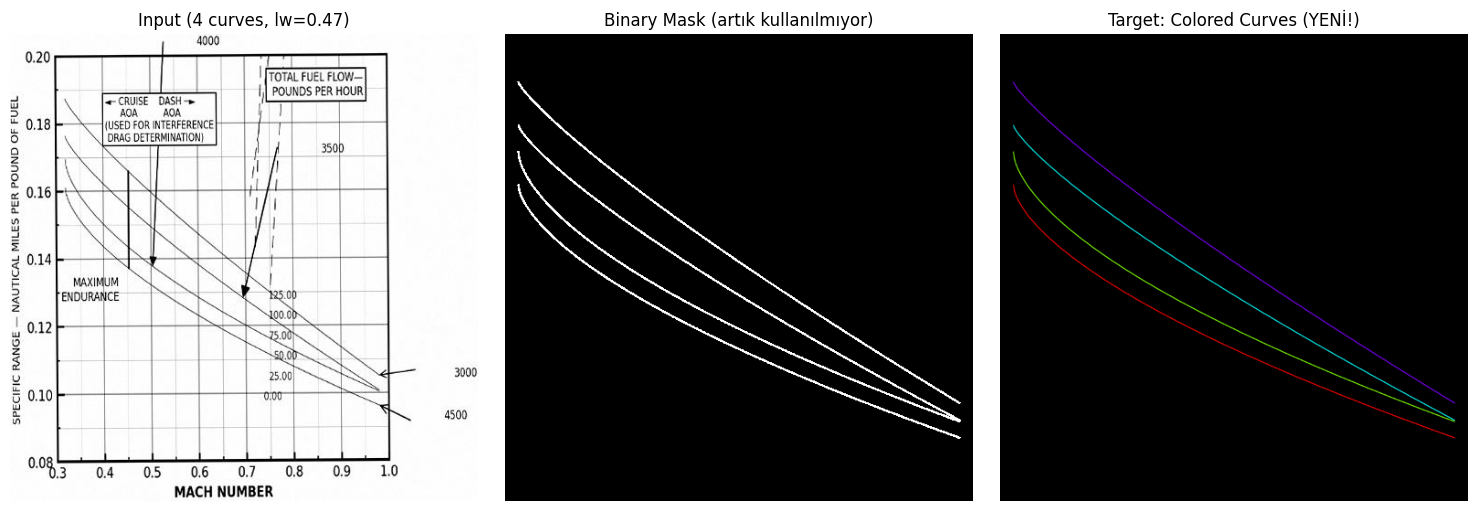

In [14]:
# Test sentetik veri üretimi
config = random_config()
full_img, mask, curves = draw_chart_matplotlib(config, W=512, H=512)
full_img = add_scan_artifacts(full_img)

# Renkli target üret
target_colored = colorize_curves_from_data(curves, config, W=512, H=512, 
                                           show_axes=False, black_background=True)
target_rgb = cv2.cvtColor(target_colored, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(full_img)
axes[0].set_title(f'Input ({config.n_curves} curves, lw={config.curve_lw:.2f})')
axes[0].axis('off')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Binary Mask (artık kullanılmıyor)')
axes[1].axis('off')
axes[2].imshow(target_rgb)
axes[2].set_title('Target: Colored Curves (YENİ!)')
axes[2].axis('off')
plt.tight_layout()
plt.show()

## 2. Veriyi Disk'e Üret (Memory-Friendly)

Bu hücre bir kez çalıştırılır, sonra veri disk'ten okunur.

In [ ]:
# ===== VERİYİ ÖNCEDEN ÜRET VE KAYDET =====
# (Config'den TOTAL_IMAGES ve SAVE_DIR kullanılıyor)

# Klasörleri oluştur
os.makedirs(f'{SAVE_DIR}/images', exist_ok=True)
os.makedirs(f'{SAVE_DIR}/targets', exist_ok=True)

# Eğer veri zaten varsa atla
existing_images = len(os.listdir(f'{SAVE_DIR}/images')) if os.path.exists(f'{SAVE_DIR}/images') else 0
if existing_images >= TOTAL_IMAGES:
    print(f"✓ Dataset already exists with {existing_images} images, skipping generation.")
else:
    print(f"Generating {TOTAL_IMAGES} images to disk...")
    for i in tqdm(range(TOTAL_IMAGES)):
        config = random_config()
        img, mask, curves_data = draw_chart_matplotlib(config, W=IMG_SIZE, H=IMG_SIZE)
        img = add_scan_artifacts(img)
        
        # Renkli target üret (siyah arka plan)
        target = colorize_curves_from_data(curves_data, config, W=IMG_SIZE, H=IMG_SIZE, 
                                           show_axes=False, black_background=True)
        
        cv2.imwrite(f'{SAVE_DIR}/images/{i:05d}.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(f'{SAVE_DIR}/targets/{i:05d}.png', target)
        
        # Memory temizle (her iterasyonda plt.close, her 25'te gc)
        plt.close('all')
        if i % 25 == 0:
            gc.collect()
    
    print(f"✅ Generated {TOTAL_IMAGES} images to {SAVE_DIR}")

Generating 3000 images to disk...


NameError: name 'tqdm' is not defined

## 3. Disk Dataset (Memory-Friendly)

In [ ]:
class DiskDataset(Dataset):
    """Disk'ten okuyan dataset - memory friendly!
    
    Artık renkli target (colored curves) okuyor, maske değil!
    """
    
    def __init__(self, data_dir, img_size=512, augment=True):
        self.data_dir = data_dir
        self.img_size = img_size
        self.augment = augment
        self.image_files = sorted(os.listdir(f'{data_dir}/images'))
        print(f"DiskDataset: Found {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Disk'ten oku
        img = cv2.imread(f'{self.data_dir}/images/{self.image_files[idx]}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Target: renkli eğriler (RGB)
        target = cv2.imread(f'{self.data_dir}/targets/{self.image_files[idx]}')
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
        
        # Resize
        img = cv2.resize(img, (self.img_size, self.img_size))
        target = cv2.resize(target, (self.img_size, self.img_size))
        
        # Augmentation
        if self.augment:
            if random.random() > 0.5:
                img = np.fliplr(img).copy()
                target = np.fliplr(target).copy()
            if random.random() > 0.5:
                # Brightness augmentation (sadece input'a)
                factor = random.uniform(0.9, 1.1)
                img = np.clip(img * factor, 0, 255).astype(np.uint8)
        
        # Tensor'a çevir
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        target = torch.from_numpy(target).permute(2, 0, 1).float() / 255.0
        
        return img, target


# Test (config'den SAVE_DIR ve IMG_SIZE kullanılıyor)
dataset = DiskDataset(SAVE_DIR, img_size=IMG_SIZE, augment=True)
img, target = dataset[0]
print(f"Image shape: {img.shape}, Target shape: {target.shape}")
print(f"Image range: [{img.min():.3f}, {img.max():.3f}]")
print(f"Target range: [{target.min():.3f}, {target.max():.3f}]")

# Görselleştir
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img.permute(1, 2, 0))
axes[0].set_title('Input (noisy chart)')
axes[0].axis('off')
axes[1].imshow(target.permute(1, 2, 0))
axes[1].set_title('Target (colored curves)')
axes[1].axis('off')
plt.show()

## 4. U-Net Model

In [ ]:
class DoubleConv(nn.Module):
    """Double convolution block."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """U-Net for image-to-image translation (colored curve extraction)."""
    
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        
        # Encoder
        for f in features:
            self.downs.append(DoubleConv(in_channels, f))
            in_channels = f
        
        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        
        # Decoder
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(f * 2, f, 2, 2))
            self.ups.append(DoubleConv(f * 2, f))
        
        self.final = nn.Conv2d(features[0], out_channels, 1)
    
    def forward(self, x):
        skip_connections = []
        
        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        # Decoder
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip = skip_connections[i // 2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
            x = torch.cat([skip, x], dim=1)
            x = self.ups[i + 1](x)
        
        return torch.sigmoid(self.final(x))


# Test model
model = UNet(out_channels=3)  # RGB output!
x = torch.randn(1, 3, 512, 512)
y = model(x)
print(f"Input: {x.shape} -> Output: {y.shape}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

## 5. Loss Function

In [ ]:
# ===== LOSS FUNCTIONS (L1 + SSIM + PERCEPTUAL) =====
import torchvision.models as models

class PerceptualLoss(nn.Module):
    """
    VGG-based Perceptual Loss.
    Eğrilerin şekil benzerliğini ölçer (piksel yerine 'görsel' karşılaştırma).
    """
    def __init__(self):
        super().__init__()
        # VGG16'nın ilk 16 katmanını al
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:16]
        self.vgg = vgg.eval()
        
        # VGG'yi freeze et
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        # ImageNet normalization
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    
    def forward(self, pred, target):
        # Normalize
        pred_norm = (pred - self.mean) / self.std
        target_norm = (target - self.mean) / self.std
        
        # VGG features
        pred_features = self.vgg(pred_norm)
        target_features = self.vgg(target_norm)
        
        return F.l1_loss(pred_features, target_features)


class CurveLoss(nn.Module):
    """
    Combined L1 + SSIM + Perceptual loss for colored curve extraction.
    L1: Piksel farkı
    SSIM: Yapısal benzerlik
    Perceptual: VGG şekil benzerliği
    """
    def __init__(self, l1_weight=0.5, ssim_weight=0.2, perceptual_weight=0.3, device='cuda'):
        super().__init__()
        self.l1_weight = l1_weight
        self.ssim_weight = ssim_weight
        self.perceptual_weight = perceptual_weight
        self.l1 = nn.L1Loss()
        
        if perceptual_weight > 0:
            self.perceptual = PerceptualLoss().to(device)
        else:
            self.perceptual = None
    
    def ssim_loss(self, pred, target, window_size=11, C1=0.01**2, C2=0.03**2):
        """Compute SSIM loss (1 - SSIM)."""
        channel = pred.shape[1]
        
        sigma = 1.5
        gauss = torch.Tensor([np.exp(-(x - window_size//2)**2 / (2 * sigma**2)) 
                              for x in range(window_size)])
        gauss = gauss / gauss.sum()
        _1D_window = gauss.unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        window = window.to(pred.device)
        
        mu1 = F.conv2d(pred, window, padding=window_size//2, groups=channel)
        mu2 = F.conv2d(target, window, padding=window_size//2, groups=channel)
        
        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2
        
        sigma1_sq = F.conv2d(pred * pred, window, padding=window_size//2, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(target * target, window, padding=window_size//2, groups=channel) - mu2_sq
        sigma12 = F.conv2d(pred * target, window, padding=window_size//2, groups=channel) - mu1_mu2
        
        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
                   ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        
        return 1 - ssim_map.mean()
    
    def forward(self, pred, target):
        l1_loss = self.l1(pred, target)
        ssim_loss = self.ssim_loss(pred, target)
        
        if self.perceptual is not None:
            perc_loss = self.perceptual(pred, target)
            total = self.l1_weight * l1_loss + self.ssim_weight * ssim_loss + self.perceptual_weight * perc_loss
        else:
            total = self.l1_weight * l1_loss + self.ssim_weight * ssim_loss
        
        return total


# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Memory temizle
gc.collect()
torch.cuda.empty_cache()

# Model
model = UNet(out_channels=3).to(device)

# ===== CHECKPOINT'TEN DEVAM (varsa) =====
START_EPOCH = 0
best_loss = float('inf')

# Best loss'u history'den al
if os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, 'r') as f:
        try:
            history = json.load(f)
            if len(history) > 0:
                best_loss = min(history)
                print(f"Loaded history: best_loss={best_loss:.4f}")
        except Exception:
            pass

# En son checkpoint'i bul ve yükle
checkpoint_files = glob.glob(f'{CHECKPOINT_DIR}/checkpoint_epoch_*.pt')
if checkpoint_files:
    def _epoch_num(path):
        try:
            return int(path.split('_epoch_')[-1].split('.pt')[0])
        except Exception:
            return -1
    latest_ckpt = max(checkpoint_files, key=_epoch_num)
    last_epoch = _epoch_num(latest_ckpt)
    if last_epoch >= 0:
        model.load_state_dict(torch.load(latest_ckpt))
        START_EPOCH = last_epoch
        print(f"✓ Loaded checkpoint: {latest_ckpt}")
        print(f"  Resuming from epoch {START_EPOCH + 1}")
else:
    print("No checkpoint found, starting from scratch.")

# Optimizer & Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=NUM_EPOCHS, last_epoch=START_EPOCH-1 if START_EPOCH > 0 else -1
)

# Loss (Perceptual dahil!)
criterion = CurveLoss(
    l1_weight=L1_WEIGHT,
    ssim_weight=SSIM_WEIGHT,
    perceptual_weight=PERCEPTUAL_WEIGHT,
    device=device
)
print(f"✅ Loss: L1({L1_WEIGHT}) + SSIM({SSIM_WEIGHT}) + Perceptual({PERCEPTUAL_WEIGHT})")

# Dataset
train_dataset = DiskDataset(SAVE_DIR, img_size=IMG_SIZE, augment=True)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
print(f"DataLoader ready: {len(train_loader)} batches per epoch")

## 6. Eğitim

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for images, targets in tqdm(loader, desc="Training"):
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def visualize_predictions(model, dataset, device, n=3):
    """Visualize model predictions (colored curves)."""
    model.eval()
    
    fig, axes = plt.subplots(n, 3, figsize=(15, 5*n))
    if n == 1:
        axes = axes.reshape(1, -1)
    
    indices = random.sample(range(len(dataset)), n)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, target = dataset[idx]
            img_tensor = img.unsqueeze(0).to(device)
            
            pred = model(img_tensor)
            pred = pred.squeeze(0).cpu()
            
            # Input image
            axes[i, 0].imshow(img.permute(1, 2, 0))
            axes[i, 0].set_title('Input')
            axes[i, 0].axis('off')
            
            # Ground truth (colored curves)
            axes[i, 1].imshow(target.permute(1, 2, 0))
            axes[i, 1].set_title('Target')
            axes[i, 1].axis('off')
            
            # Prediction (colored curves)
            axes[i, 2].imshow(pred.permute(1, 2, 0))
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    model.train()

In [ ]:
# Training loop
history = []

# Eğer önceki history varsa devam et
if os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, 'r') as f:
        try:
            history = json.load(f)
            print(f"Loaded history with {len(history)} points")
        except Exception:
            history = []

print(f"\n🚀 Starting training from epoch {START_EPOCH + 1}...\n")

for epoch in range(START_EPOCH, NUM_EPOCHS):
    loss = train_epoch(model, train_loader, criterion, optimizer, device)
    scheduler.step()
    
    history.append(loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {loss:.4f} - LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # En iyi modeli kaydet
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), f'{CHECKPOINT_DIR}/best_model.pt')
        print(f"🏆 New best model! Loss: {loss:.4f}")
    
    # Her epoch checkpoint kaydet
    torch.save(model.state_dict(), f'{CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pt')
    
    # History kaydet (kalıcı)
    with open(HISTORY_PATH, 'w') as f:
        json.dump(history, f)
    
    # Her N epoch'ta görselleştir
    if (epoch + 1) % VISUALIZE_EVERY == 0:
        visualize_predictions(model, train_dataset, device, n=2)
    
    # Memory temizle
    gc.collect()
    torch.cuda.empty_cache()

print(f"\n✅ Training complete! Best loss: {best_loss:.4f}")

In [ ]:
# Loss grafiği
if os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, 'r') as f:
        history = json.load(f)
    plt.figure(figsize=(10, 4))
    plt.plot(history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss (L1 + SSIM + Perceptual)')
    plt.grid(True)
    plt.show()
else:
    print("history.json bulunamadı.")

## 7. Model Kaydetme

In [ ]:
# Final model kaydet
torch.save(model.state_dict(), f'{CHECKPOINT_DIR}/curve_unet_final.pt')
print(f"✓ Final model saved: curve_unet_final.pt")
print(f"✓ Best model saved: best_model.pt (loss: {best_loss:.4f})")

# Tüm output dosyalarını listele
print(f"\n📁 Output files in {CHECKPOINT_DIR}:")
for f in os.listdir(CHECKPOINT_DIR):
    if f.endswith('.pt'):
        size_mb = os.path.getsize(f'{CHECKPOINT_DIR}/{f}') / (1024*1024)
        print(f"  {f} ({size_mb:.1f} MB)")

In [ ]:
# ===== Toplu model testi (Kaggle working) =====
import glob
import os

# Buradan seç:
USE_MODELS_DIR = False  # models klasörün yoksa False bırak
MODELS_DIR = '/kaggle/working/models'  # varsa kullanılır

# Belirli epoch'ları test etmek için liste ver (ör: [10, 20, 30])
SELECT_EPOCHS = []  # boş bırakılırsa tüm checkpoint'ler

# Hangi .pt dosyalarını test edeceğini topla
if USE_MODELS_DIR and os.path.isdir(MODELS_DIR):
    model_paths = sorted(glob.glob(os.path.join(MODELS_DIR, '*.pt')))
else:
    model_paths = sorted(glob.glob('/kaggle/working/checkpoint_epoch_*.pt'))
    # best ve final'ı da dahil et
    extra = []
    if os.path.exists('/kaggle/working/best_model.pt'):
        extra.append('/kaggle/working/best_model.pt')
    if os.path.exists('/kaggle/working/curve_unet_final.pt'):
        extra.append('/kaggle/working/curve_unet_final.pt')
    model_paths += extra

# Eğer seçili epoch listesi varsa filtrele
if SELECT_EPOCHS:
    selected = []
    for e in SELECT_EPOCHS:
        p = f'/kaggle/working/checkpoint_epoch_{e}.pt'
        if os.path.exists(p):
            selected.append(p)
    # best/final da ekleyebilirsin
    if os.path.exists('/kaggle/working/best_model.pt'):
        selected.append('/kaggle/working/best_model.pt')
    if os.path.exists('/kaggle/working/curve_unet_final.pt'):
        selected.append('/kaggle/working/curve_unet_final.pt')
    model_paths = selected

# tekrar sıralayıp tekilleştir
model_paths = sorted(set(model_paths))
print(f"Found {len(model_paths)} models")

if len(model_paths) == 0:
    print("Hiç .pt bulunamadı. /kaggle/working altında checkpoint var mı kontrol et.")
else:
    # Sabit bir sentetik örnek oluştur (karşılaştırma için)
    test_config = random_config()
    test_img, _, curves = draw_chart_matplotlib(test_config, W=512, H=512)
    test_img = add_scan_artifacts(test_img)
    
    # Ground truth target
    target_colored = colorize_curves_from_data(curves, test_config, W=512, H=512, 
                                               show_axes=False, black_background=True)
    target_rgb = cv2.cvtColor(target_colored, cv2.COLOR_BGR2RGB)

    # Tensor hazırlık
    img_tensor = torch.from_numpy(test_img).permute(2, 0, 1).float() / 255.0
    target_tensor = torch.from_numpy(target_rgb).permute(2, 0, 1).float() / 255.0

    def mse_score(pred, target):
        """Mean Squared Error between predicted and target."""
        return ((pred - target) ** 2).mean().item()
    
    def psnr_score(pred, target, max_val=1.0):
        """Peak Signal-to-Noise Ratio."""
        mse = ((pred - target) ** 2).mean().item()
        if mse == 0:
            return float('inf')
        return 10 * np.log10(max_val**2 / mse)

    results = []
    for p in model_paths:
        model.load_state_dict(torch.load(p, map_location=device))
        model.eval()
        with torch.no_grad():
            pred = model(img_tensor.unsqueeze(0).to(device)).cpu().squeeze()
        mse = mse_score(pred, target_tensor)
        psnr = psnr_score(pred, target_tensor)
        results.append((p, mse, psnr))
        print(f"{os.path.basename(p)} -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB")

    # En iyi 3'ü göster (en düşük MSE)
    results.sort(key=lambda x: x[1])  # MSE'ye göre sırala (düşük = iyi)
    print("\nTop 3 models (lowest MSE):")
    for p, mse, psnr in results[:3]:
        print(f"  {os.path.basename(p)} -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB")

    # En iyi modeli görselleştir
    best_path = results[0][0]
    model.load_state_dict(torch.load(best_path, map_location=device))
    print(f"\nBest model selected: {os.path.basename(best_path)}")
    _ = predict_and_show(model, test_img, device)

## 8. Test - Gerçek Görüntü Üzerinde

In [ ]:
def predict_and_show(model, image_path_or_array, device):
    """Predict colored curves on an image."""
    model.eval()
    
    if isinstance(image_path_or_array, str):
        img = cv2.imread(image_path_or_array)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = image_path_or_array
    
    # Resize and normalize
    orig_h, orig_w = img.shape[:2]
    img_resized = cv2.resize(img, (512, 512))
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255.0
    
    with torch.no_grad():
        pred = model(img_tensor.unsqueeze(0).to(device)).cpu().squeeze()
    
    # Convert to numpy (RGB)
    pred_rgb = pred.permute(1, 2, 0).numpy()
    pred_rgb = np.clip(pred_rgb * 255, 0, 255).astype(np.uint8)
    
    # Resize back
    pred_full = cv2.resize(pred_rgb, (orig_w, orig_h))
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title('Input')
    axes[0].axis('off')
    
    axes[1].imshow(pred_rgb)
    axes[1].set_title('Predicted Curves (512x512)')
    axes[1].axis('off')
    
    axes[2].imshow(pred_full)
    axes[2].set_title('Predicted Curves (Original Size)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return pred_full


# Test on synthetic
test_config = random_config()
test_img, _, curves = draw_chart_matplotlib(test_config, W=800, H=600)
test_img = add_scan_artifacts(test_img)
pred_curves = predict_and_show(model, test_img, device)

In [ ]:
# Gerçek görüntü yükle (opsiyonel)
# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#     pred_mask = predict_and_show(model, fn, device)